In [1]:
%load_ext autoreload
%autoreload 2

# Simple Regression Tests


In [2]:
import os
import sys
from pathlib import Path

# add the
ROOT = Path(os.getcwd())
while not (ROOT / ".git").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

from src.config import CargoBikeConfig, load_config
from src.osm_tags import build_tag_filter


import polars as pl
import geopolars as gpl
import geopandas as gpd
import pandas as pd

## Load Config


In [3]:
config = load_config(ROOT / "config" / "paper.yaml")

In [4]:
h3_df = pd.concat(
    [gpd.read_parquet(city.h3_file).assign(city=city.name) for city in config.Cities],
    axis=0,
).query("is_city")

h3_df.head()

,geometry,is_city,city
region_id,,,
892a339a5afffff,"POLYGON ((-71.13572 42.23376, -71.13794 42.232...",True,"Boston, USA"
892a3066a3bffff,"POLYGON ((-71.08114 42.30902, -71.08337 42.308...",True,"Boston, USA"
892a302a567ffff,"POLYGON ((-70.82381 42.36269, -70.82604 42.361...",True,"Boston, USA"
892a3066e17ffff,"POLYGON ((-71.06072 42.33323, -71.06295 42.332...",True,"Boston, USA"
892a3066b3bffff,"POLYGON ((-71.06614 42.29023, -71.06837 42.289...",True,"Boston, USA"


In [5]:
pl.read_parquet(config.ServiceTime[-1].file)['has_time_window'].sum() / pl.read_parquet(config.ServiceTime[-1].file)['has_time_window'].shape[0]

0.06473257396563986

In [6]:
def open_df(city):
    df = pl.read_parquet(city.file)
    return df.select(
        [
            pl.col(("region_id" if "region_id" in df.columns else "h3")).alias(
                "region_id"
            ),
            pl.col(city.service_time_col).cast(float).alias("service_time"),
        ]
    )


## Load the Service Time Data
service_time_df = pl.concat(
    [open_df(city) for city in config.ServiceTime],
)

# this does two things, one adds the city label and 2, it crops to the city limits
service_time_df = (
    service_time_df.join(
        pl.DataFrame(h3_df.reset_index()[["region_id", "city"]]),
        on="region_id",
        how="inner",
    )
    # .with_columns(
    #     pl.when(pl.col("city").str.contains("USA"))
    #     .then(pl.col("service_time"))
    #     .otherwise((pl.col("service_time") - 30).clip(0))
    #     .alias("service_time")
    # )
    .with_columns(
        [
            pl.col("service_time").log().alias("service_time_log"),
        ]
    )
    .filter(pl.col("service_time") > 0)
)

service_time_df = service_time_df.with_columns(
    pl.count().over("region_id").alias("h3_count")
)

In [7]:
service_time_df.head()

region_id,service_time,city,service_time_log,h3_count
str,f64,str,f64,u32
"""891fa441b53fff…",185.0,"""Brussels, Belg…",5.220356,224
"""891fa441bdbfff…",309.0,"""Brussels, Belg…",5.733341,280
"""891fa441b83fff…",197.0,"""Brussels, Belg…",5.283204,250
"""891fa44194ffff…",566.0,"""Brussels, Belg…",6.338594,43
"""891fa4419b3fff…",64.0,"""Brussels, Belg…",4.158883,1


## Summary of Service Time


In [8]:
print(
    service_time_df.group_by("city")
    .agg(
        pl.count(),
        pl.col("service_time").mean().alias("mean_service_time"),
        pl.col("service_time").std().alias("std_service_time"),
        pl.col("service_time").quantile(0.1).alias("service_time_10"),
        pl.col("service_time").quantile(0.5).alias("service_time_50"),
        pl.col("service_time").quantile(0.9).alias("service_time_90"),
        pl.col("service_time").max().alias("max_service_time"),
    )
    .sort("city")
    .with_columns(pl.col("city").str.split(", ").list.get(1).alias("country"))
    .sort(["country", "city"])
    .drop("country")
    .to_pandas()
    .round(0)
    .to_latex(
        float_format="%.0f",
        index=False,
    )
)

\begin{tabular}{lrrrrrrr}
\toprule
city & count & mean_service_time & std_service_time & service_time_10 & service_time_50 & service_time_90 & max_service_time \\
\midrule
Brussels, Belgium & 12072 & 246 & 126 & 114 & 223 & 417 & 1813 \\
London, UK & 9592 & 242 & 154 & 95 & 210 & 429 & 2407 \\
Austin, USA & 30482 & 115 & 131 & 35 & 75 & 232 & 3342 \\
Boston, USA & 22015 & 178 & 220 & 44 & 113 & 365 & 7325 \\
Chicago, USA & 41074 & 144 & 148 & 40 & 97 & 304 & 2992 \\
Seattle, USA & 57086 & 172 & 181 & 54 & 119 & 339 & 5637 \\
\bottomrule
\end{tabular}



## Comparison Statistics


In [9]:
from scipy.stats import mannwhitneyu


res = mannwhitneyu(
    service_time_df.filter(pl.col("city").str.contains("Brussels"))["service_time"],
    service_time_df.filter(pl.col("city").str.contains("London"))["service_time"],
    alternative="two-sided",
)


# science format the statistic
print(f"$U={res.statistic:.0f}, p < {res.pvalue:.2f}$")

$U=61545841, p < 0.00$


In [10]:
service_time_df.filter(pl.col("city").str.contains("USA"))["service_time"].describe()

statistic,value
str,f64
"""count""",150657.0
"""null_count""",0.0
"""mean""",153.593251
"""std""",171.575362
"""min""",4.8
"""25%""",61.0
"""50%""",102.0
"""75%""",183.0
"""max""",7325.0


In [11]:
service_time_df.filter(~pl.col("city").str.contains("USA"))["service_time"].describe()

statistic,value
str,f64
"""count""",23900.0
"""null_count""",0.0
"""mean""",248.791757
"""std""",132.267856
"""min""",1.0
"""25%""",157.0
"""50%""",222.0
"""75%""",309.0
"""max""",1813.0


In [27]:
from scipy.stats import mannwhitneyu


res = mannwhitneyu(
    service_time_df.filter(~pl.col("city").str.contains("USA"))["service_time"],
    service_time_df.filter(pl.col("city").str.contains("USA"))["service_time"],
    alternative="two-sided",
)


# science format the statistic
print(f"$U={res.statistic:.0f}, p < {res.pvalue:.2f}$")

$U=2779887627, p < 0.00$


In [10]:
from scipy.stats import levene


res = levene(
    service_time_df.filter(pl.col("city").str.contains("Brussels"))["service_time"],
    service_time_df.filter(pl.col("city").str.contains("London"))["service_time"],
)


# science format the statistic
print(f"$F={res.statistic:.2f}, p = {res.pvalue:.2f}$")

$F=97.20, p = 0.00$


In [14]:
# print(
#     service_time_df
#     .group_by("city")
#     .agg(
#         pl.count(),
#         pl.col("service_time").mean().alias("mean_service_time"),
#         pl.col("service_time").std().alias("std_service_time"),
#         pl.col("service_time").quantile(0.1).alias("service_time_10"),
#         pl.col("service_time").quantile(0.5).alias("service_time_50"),
#         pl.col("service_time").quantile(0.9).alias("service_time_90"),
#         pl.col("service_time").max().alias("max_service_time"),
#     )
#     .sort("city")
#     .to_pandas()
#     .round(2)
#     .to_latex(
#         float_format="%.2f",
#     )
# )

## Plot Distribution of Vans vs. London & Brussels


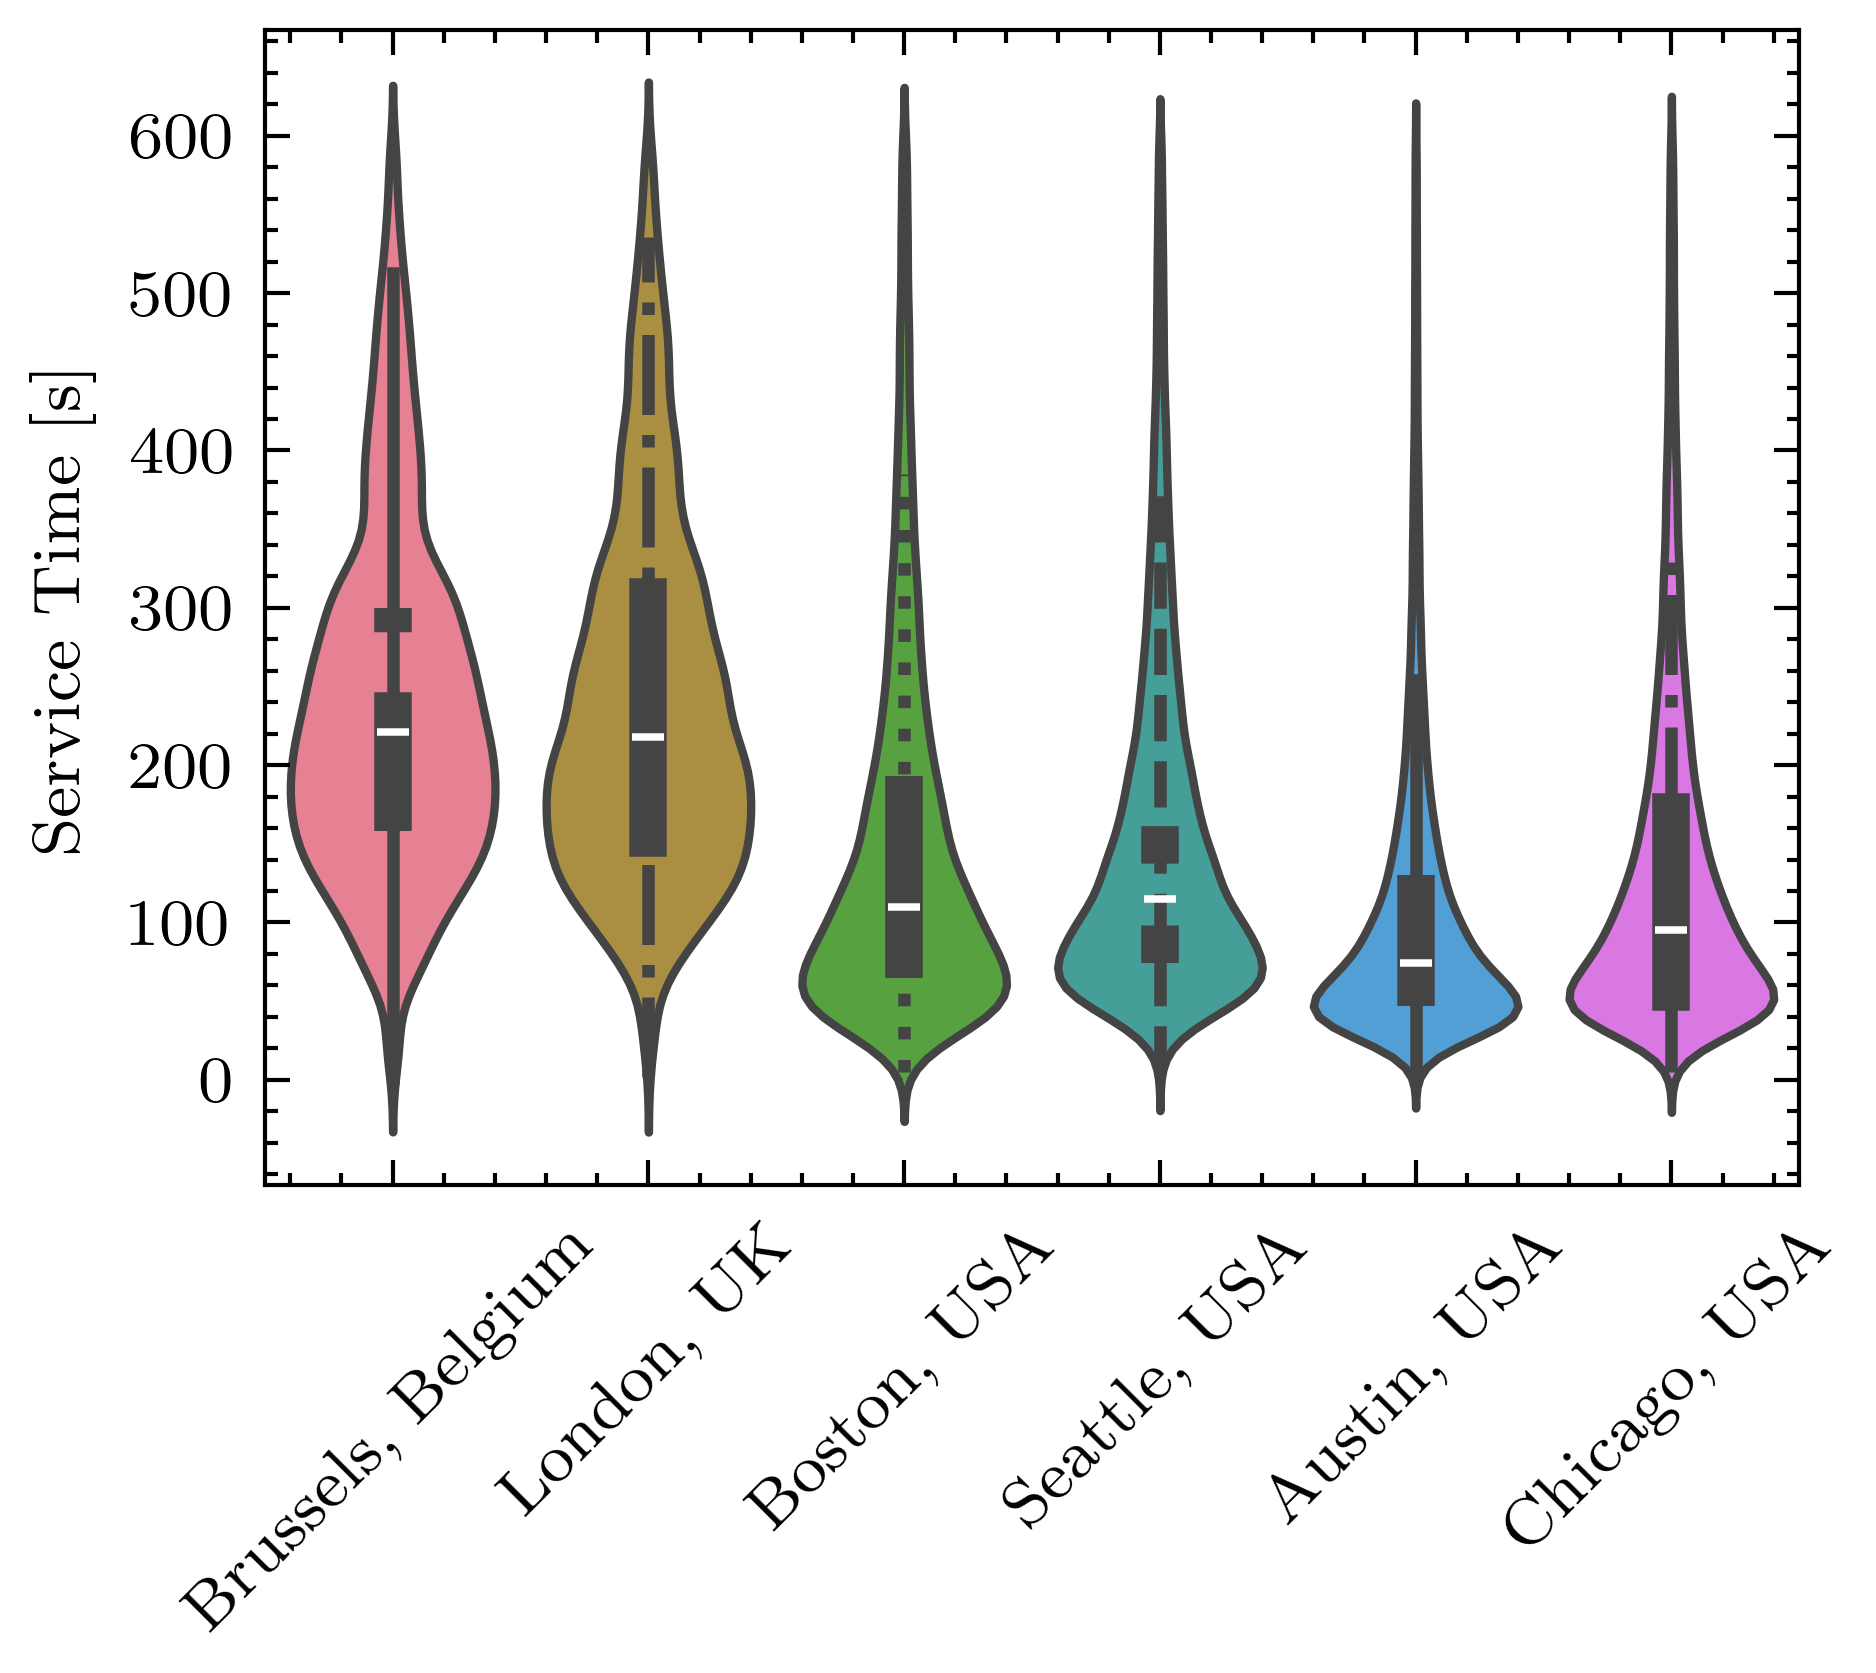

In [15]:
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use(["science", "ieee"])

fig, ax = plt.subplots()

sns.violinplot(
    data=service_time_df.filter(pl.col("service_time") < 600).to_pandas(),
    x="city",
    y="service_time",
    ax=ax,
    hue="city",
    linewidth=1,
    # log_scale=True,
    # order=["Brussels", "London"],
    # palette=["#e41a1c", "#377eb8"],
)

ax.set_ylabel("Service Time [s]")
ax.set_xlabel("")

# rotate teh x labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

## Fit Distribution of Vans vs. London & Brussels

In [16]:
from distfit import distfit

In [17]:
# dist.plot_summary()

In [18]:
# Import library

boston_df = service_time_df.filter(pl.col("city").str.contains("Boston"))

dist = distfit(stats='RSS')
res = dist.fit_transform(boston_df["service_time"].to_numpy())

# dist.plot_summary()
# fig, ax = dist.plot()

# # make smaller
# fig.set_size_inches(4, 3)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000165875] [loc=177.587 scale=220.319]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 7.70694e-05] [loc=5.000 scale=172.587]


[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 8.56351e-05] [loc=-1536.024 scale=1541.024]
[distfit] >INFO> [dweibull  ] [0.23 sec] [RSS: 6.10636e-05] [loc=95.000 scale=93.343]
[distfit] >INFO> [t         ] [0.67 sec] [RSS: 5.27725e-05] [loc=106.172 scale=62.459]
[distfit] >INFO> [genextreme] [0.74 sec] [RSS: 2.6004e-06] [loc=86.480 scale=62.555]
[distfit] >INFO> [gamma     ] [0.15 sec] [RSS: 0.000360897] [loc=5.000 scale=3.938]
[distfit] >INFO> [lognorm   ] [0.22 sec] [RSS: 0.00053489] [loc=5.000 scale=2.559]
[distfit] >INFO> [beta      ] [0.31 sec] [RSS: 4.24552e-05] [loc=4.986 scale=1938760.460]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000347462] [loc=5.000 scale=7320.000]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 0.000177445] [loc=-86017.190 scale=11273.814]
[distfit] >INFO> Compute confidence intervals [parametric]


In [19]:
res['summary']

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,genextreme,0.000003,86.479722,62.555372,"(-0.54223463016291,)","(-0.54223463016291, 86.47972216451357, 62.5553...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,beta,0.000042,4.98563,1938760.460447,"(1.3210927933397434, 14681.300914926713)","(1.3210927933397434, 14681.300914926713, 4.985...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,t,0.000053,106.172356,62.458937,"(1.5150498598440523,)","(1.5150498598440523, 106.17235575525368, 62.45...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#377eb8
3,dweibull,0.000061,95.0,93.343003,"(0.7845340438317202,)","(0.7845340438317202, 94.99999999999997, 93.343...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#4daf4a
4,expon,0.000077,5.0,172.587127,(),"(5.0, 172.58712695889167)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#984ea3
5,pareto,0.000086,-1536.02367,1541.02367,"(9.984459382604213,)","(9.984459382604213, -1536.0236701731444, 1541....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ff7f00
6,norm,0.000166,177.587127,220.318923,(),"(177.58712695889167, 220.31892288793975)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ffff33
7,loggamma,0.000177,-86017.190151,11273.813689,"(2091.7548874618587,)","(2091.7548874618587, -86017.19015071806, 11273...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#a65628
8,uniform,0.000347,5.0,7320.0,(),"(5.0, 7320.0)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#f781bf
9,gamma,0.000361,5.0,3.937529,"(0.004335028120553,)","(0.004335028120553, 4.999999999999999, 3.93752...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


In [20]:
# Import library

boston_df = service_time_df.filter(pl.col("city").str.contains("Seattle"))

dist = distfit()
res = dist.fit_transform(boston_df["service_time"].to_numpy())

# dist.plot_summary()
dist.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000246813] [loc=171.505 scale=180.752]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.000187506] [loc=4.800 scale=166.705]
[distfit] >INFO> [pareto    ] [0.02 sec] [RSS: 0.000192679] [loc=-6015.220 scale=6020.020]
[distfit] >INFO> [dweibull  ] [0.45 sec] [RSS: 0.000113307] [loc=103.000 scale=87.961]
[distfit] >INFO> [t         ] [1.69 sec] [RSS: 9.15947e-05] [loc=113.913 scale=60.013]
[distfit] >INFO> [genextreme] [2.34 sec] [RSS: 1.03641e-05] [loc=95.072 scale=60.551]
[distfit] >INFO> [gamma     ] [0.30 sec] [RSS: 0.000588746] [loc=4.800 scale=4.330]
[distfit] >INFO> [lognorm   ] [0.41 sec] [RSS: 0.00118185] [loc=4.800 scale=2.577]
[distfit] >INFO> [beta      ] [0.71 sec] [RSS: 7.32516e-05] [loc=4.793 scale=14672343283.561]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000561743] [loc=4.800 scale=5632.300]
[distfit] >INFO> [loggamma  ] [0.32 sec] [RSS: 0.000260895] [loc=-63967.549 sca

(<Figure size 12000x9000 with 1 Axes>,
 <Axes: title={'center': '\ngenextreme(c=-0.447956, loc=95.0723, scale=60.5511)'}, xlabel='Values', ylabel='Frequency'>)

[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using

In [21]:
service_time_df.filter(pl.col("city").str.contains("London"))['service_time'].quantile(0.01)

52.0

In [22]:
# Import library

boston_df = service_time_df.filter(pl.col("city").str.contains("London"))

dist = distfit()
res = dist.fit_transform(boston_df["service_time"].to_numpy())

# dist.plot_summary()
dist.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 2.23399e-05] [loc=251.611 scale=138.428]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 9.0649e-05] [loc=2.000 scale=249.611]
[distfit] >INFO> [pareto    ] [0.02 sec] [RSS: 9.0649e-05] [loc=-68719476734.000 scale=68719476736.000]
[distfit] >INFO> [dweibull  ] [0.13 sec] [RSS: 1.37248e-05] [loc=229.520 scale=105.300]
[distfit] >INFO> [t         ] [0.42 sec] [RSS: 2.28069e-05] [loc=251.328 scale=138.810]
[distfit] >INFO> [genextreme] [0.38 sec] [RSS: 1.26513e-06] [loc=187.572 scale=94.892]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 0.000186829] [loc=2.000 scale=2.813]
[distfit] >INFO> [lognorm   ] [0.14 sec] [RSS: 0.000290446] [loc=2.000 scale=2.914]
[distfit] >INFO> [beta      ] [0.17 sec] [RSS: 4.12358e-06] [loc=0.093 scale=201145163.403]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000140795] [loc=2.000 scale=1602.000]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 2.28634e-05] [loc=

(<Figure size 12000x9000 with 1 Axes>,
 <Axes: title={'center': '\ngenextreme(c=-0.0902825, loc=187.572, scale=94.8924)'}, xlabel='Values', ylabel='Frequency'>)

[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using

In [23]:
# Import library

boston_df = service_time_df.filter(pl.col("city").str.contains("Brussels"))

dist = distfit()
res = dist.fit_transform(boston_df["service_time"].to_numpy())

# dist.plot_summary()
dist.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 1.85586e-05] [loc=246.029 scale=125.873]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.000109047] [loc=1.000 scale=245.029]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 0.000109047] [loc=-17179869183.000 scale=17179869184.000]
[distfit] >INFO> [dweibull  ] [0.15 sec] [RSS: 1.02758e-05] [loc=229.599 scale=97.546]
[distfit] >INFO> [t         ] [0.47 sec] [RSS: 9.7792e-06] [loc=230.130 scale=96.817]
[distfit] >INFO> [genextreme] [0.38 sec] [RSS: 1.5295e-06] [loc=189.219 scale=94.391]
[distfit] >INFO> [gamma     ] [0.11 sec] [RSS: 0.000218736] [loc=1.000 scale=2.292]
[distfit] >INFO> [lognorm   ] [0.11 sec] [RSS: 0.00037629] [loc=1.000 scale=4.690]
[distfit] >INFO> [beta      ] [0.14 sec] [RSS: 3.40324e-06] [loc=-17.433 scale=5330.914]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000169041] [loc=1.000 scale=1812.000]
[distfit] >INFO> [loggamma  ] [0.09 sec] [RSS: 1.9569e-05] [loc=-33297.

(<Figure size 12000x9000 with 1 Axes>,
 <Axes: title={'center': '\ngenextreme(c=-0.0248936, loc=189.219, scale=94.3906)'}, xlabel='Values', ylabel='Frequency'>)

[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using default.
[distfit] >INFO> No LaTeX-compatible font found for the serif fontfamily in rcParams. Using

### Just Cargo Vans


In [24]:
print(
    service_time_df.filter(pl.col("city").str.contains("USA"))
    .select(
        pl.count(),
        pl.col("service_time").mean().alias("mean_service_time"),
        pl.col("service_time").std().alias("std_service_time"),
        pl.col("service_time").quantile(0.1).alias("service_time_10"),
        pl.col("service_time").quantile(0.5).alias("service_time_50"),
        pl.col("service_time").quantile(0.9).alias("service_time_90"),
        pl.col("service_time").max().alias("service_time_max"),
    )
    .to_pandas()
    .round(2)
    .to_latex(
        float_format="%.2f",
    )
)

\begin{tabular}{lrrrrrrr}
\toprule
 & count & mean_service_time & std_service_time & service_time_10 & service_time_50 & service_time_90 & service_time_max \\
\midrule
0 & 150657 & 153.59 & 171.58 & 42.00 & 102.00 & 314.00 & 7325.00 \\
\bottomrule
\end{tabular}



In [11]:
153.59 / 60

2.559833333333333